In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("./data/", one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
def batch_norm_layer(inputs, is_training=None, name=None, decay=0.999, epsilon=1e-5):
    """
    Batch-Normalization Layer
    
    params
    ======
    - inputs: input Tensor
    - name(Optional): name of the layer
    - decay(Optional): decay rate of moving average of input moments
    - epsilon(Optional): epsilon to advoid dividing by 0.
    
    returns
    =======
    - is_training: a placeholder of type tf.bool. If the value is `True`, the
    layer will run in training phase, otherwise running in inference phase.
    - outputs: batch normalized outputs
    """
    if is_training is None:
        is_training = tf.placeholder(tf.bool, name="is_training")
    
    N_features = inputs.get_shape()[-1]
    scale = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="scale")
    offset = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="offset")
    
    moving_mean = tf.Variable(tf.zeros(N_features), 
                              trainable=False,
                              name="moving_mean")
    moving_vars = tf.Variable(tf.ones(N_features),
                              trainable=False,
                              name="moving_vars")
    
    def fn_inference(): 
        return tf.nn.batch_normalization(inputs,
                                         moving_mean,
                                         moving_vars,
                                         offset,
                                         scale,
                                         epsilon)
    
    # Follow the recommanded implementation in this issue 
    # https://github.com/tensorflow/tensorflow/issues/3287
    def fn_training():
        inputs_mean, inputs_vars = tf.nn.moments(inputs, 1)
        update_mean_op = tf.assign(moving_mean, decay*moving_mean+(1-decay)*inputs_mean)
        update_vars_op = tf.assign(moving_vars, decay*moving_vars+(1-decay)*inputs_vars)
        with tf.control_dependencies([update_mean_op, update_vars_op]):
            train_outputs = tf.nn.batch_normalization(inputs, 
                                                      inputs_mean, 
                                                      inputs_vars,
                                                      offset,
                                                      scale,
                                                      epsilon)
        return train_outputs 
    
    outputs = tf.cond(is_training, 
                      true_fn=fn_training, 
                      false_fn=fn_inference, 
                      name=name)
    return outputs, is_training

In [4]:
graph = tf.Graph()
with graph.as_default():
    is_training = tf.placeholder(tf.bool)
    x_ = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # layer 1
    W1 = tf.Variable(np.random.randn(784, 100), dtype=tf.float32)
    z1 = tf.matmul(x_, W1)
    a1, _ = batch_norm_layer(z1, is_training)
    l1 = tf.nn.sigmoid(a1)
    
    # layer 2
    W2 = tf.Variable(np.random.randn(100, 100), dtype=tf.float32)
    z2 = tf.matmul(l1, W2)
    a2, _ = batch_norm_layer(z2, is_training)
    l2 = tf.nn.sigmoid(a2)
    
    # layer 3
    W3 = tf.Variable(np.random.randn(100, 10), dtype=tf.float32)
    z3 = tf.matmul(l2, W3)
    y = tf.nn.softmax(z3)
    predict = tf.arg_max(y, 1)
    
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy)

In [5]:
def comput_accuracy(y1, y2):
    return (y1 == y2).mean()

In [6]:
n_iterations = 40000
batch_size = 100

losses = [None for _ in range(n_iterations)]
accuracy = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels,
                      is_training:True}
        _, l = sess.run([train_op, cross_entropy], feed_dict=feed_dict)
        losses[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = mnist.test.images
            feed_dict[y_] = mnist.test.labels
            feed_dict[is_training] = False
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = comput_accuracy(pred, np.argmax(mnist.test.labels, 1))
            accuracy.append(acc)
            print("Iteration {}: loss {}, acuuracy {:.2f}%".format(step+1, l, acc*100))

Iteration 1000: loss 34.276390075683594, acuuracy 89.69%
Iteration 2000: loss 38.356964111328125, acuuracy 92.16%
Iteration 3000: loss 28.345413208007812, acuuracy 93.62%
Iteration 4000: loss 14.757301330566406, acuuracy 94.43%
Iteration 5000: loss 27.518741607666016, acuuracy 94.53%
Iteration 6000: loss 23.262929916381836, acuuracy 95.45%
Iteration 7000: loss 37.20282745361328, acuuracy 95.39%
Iteration 8000: loss 6.962925434112549, acuuracy 95.44%
Iteration 9000: loss 9.383466720581055, acuuracy 95.91%
Iteration 10000: loss 11.802200317382812, acuuracy 96.13%
Iteration 11000: loss 6.6444807052612305, acuuracy 96.30%
Iteration 12000: loss 1.885927438735962, acuuracy 96.26%
Iteration 13000: loss 9.867752075195312, acuuracy 96.24%
Iteration 14000: loss 26.750812530517578, acuuracy 96.30%
Iteration 15000: loss 9.424698829650879, acuuracy 96.39%
Iteration 16000: loss 5.705284118652344, acuuracy 96.65%
Iteration 17000: loss 6.705729961395264, acuuracy 96.33%
Iteration 18000: loss 3.5177969

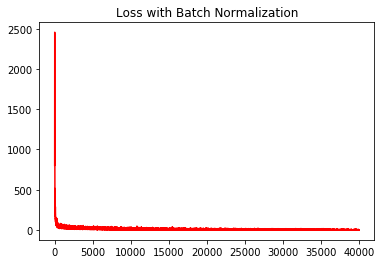

In [7]:
plt.title("Loss with Batch Normalization")
plt.plot(losses, "r-")

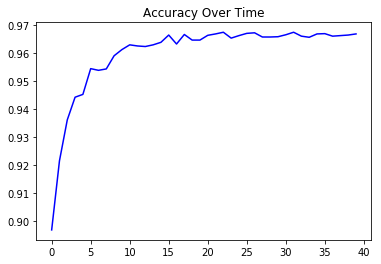

In [8]:
plt.title("Accuracy Over Time")
plt.plot(accuracy, "b-")